In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

if not os.getcwd().endswith('mob2crime'):
    os.chdir('..')
os.getcwd()

'/home/Jiahui/mob2crime'

In [3]:
import geopandas as gp
from shapely.geometry import Polygon, LineString, box
import numpy as np
import fiona
import src.mex_helper as mex

In [4]:
from src.utils.gis import *

In [5]:
%matplotlib inline

In [6]:
%load_ext line_profiler

In [7]:
mex_region =  mex.regions('urban_areas_16')

In [8]:
poly = mex_region.loc['Culiacán Rosales, Sinaloa'].geometry

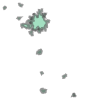

In [9]:
poly

In [10]:
gp_poly = gp.GeoDataFrame([p for p in poly], columns=['geometry'])
assign_crs(gp_poly, 4326)

In [48]:
gp_poly_ch = gp.GeoDataFrame([p.convex_hull for p in poly], columns=['geometry'])
assign_crs(gp_poly_ch, 4326)

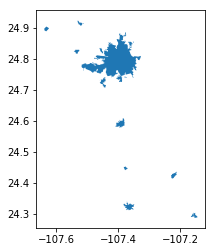

In [51]:
gp_poly.plot()

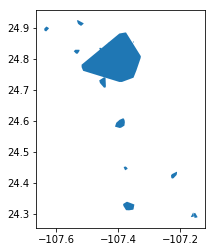

In [49]:
gp_poly_ch.plot()

In [31]:
grids = gp_polys_to_grids(gp_poly, 2000, cur_crs=4326, eqdc_crs=mex.EQDC_CRS)

gp_polys_to_grids 0
1087186.4120374057 4000000
gp_polys_to_grids 1
662197.3159643724 4000000
gp_polys_to_grids 2
4931694.60177571 4000000
gp_polys_to_grids 3
2179926.3302483456 4000000
gp_polys_to_grids 4
871129.4287522075 4000000
gp_polys_to_grids 5
5201012.367013162 4000000
gp_polys_to_grids 6
18350.329514122895 4000000
gp_polys_to_grids 7
2504.547172071668 4000000
gp_polys_to_grids 8
1465036.4775074327 4000000
gp_polys_to_grids 9
1491040.9597904135 4000000
gp_polys_to_grids 10
1286594.471624221 4000000
gp_polys_to_grids 11
2717.1955142627758 4000000
gp_polys_to_grids 12
57621.770960187874 4000000
gp_polys_to_grids 13
25617.120476189557 4000000
gp_polys_to_grids 14
622.7248854590048 4000000
gp_polys_to_grids 15
1988.9972369175093 4000000
gp_polys_to_grids 16
978476.3998355074 4000000
gp_polys_to_grids 17
69988.84933257126 4000000
gp_polys_to_grids 18
15056.954348671006 4000000
gp_polys_to_grids 19
201164.19449686815 4000000
gp_polys_to_grids 20
1196099.1666475171 4000000
gp_polys_to_

In [56]:
grids_ch = gp_polys_to_grids(gp_poly_ch, 2000, cur_crs=4326, eqdc_crs=mex.EQDC_CRS)

In [58]:
grids_ch.shape[0]

112

In [59]:
grids_ch.groupby('poly').size()

poly
0      1
1      1
2      4
3      4
4      1
5      4
6      1
7      1
8      1
9      1
10     3
11     1
12     1
13     1
14     1
15     1
16     2
17     1
18     1
19     1
20     1
21     1
22     1
23     1
24     1
25     1
26     1
27     1
28     3
29     1
30    68
dtype: int64

In [32]:
grids.groupby('poly').size()

poly
0      1
1      1
2      4
3      4
4      1
5      4
6      1
7      1
8      1
9      1
10     3
11     1
12     1
13     1
14     1
15     1
16     2
17     1
18     1
19     1
20     1
21     1
22     1
23     1
24     1
25     1
26     1
27     1
28     3
29     1
30    56
dtype: int64

In [39]:
areas = grids[grids.poly==30].to_crs(epsg=mex.AREA_CRS).area/2000/2000

In [40]:
(areas<0.5).sum()

23

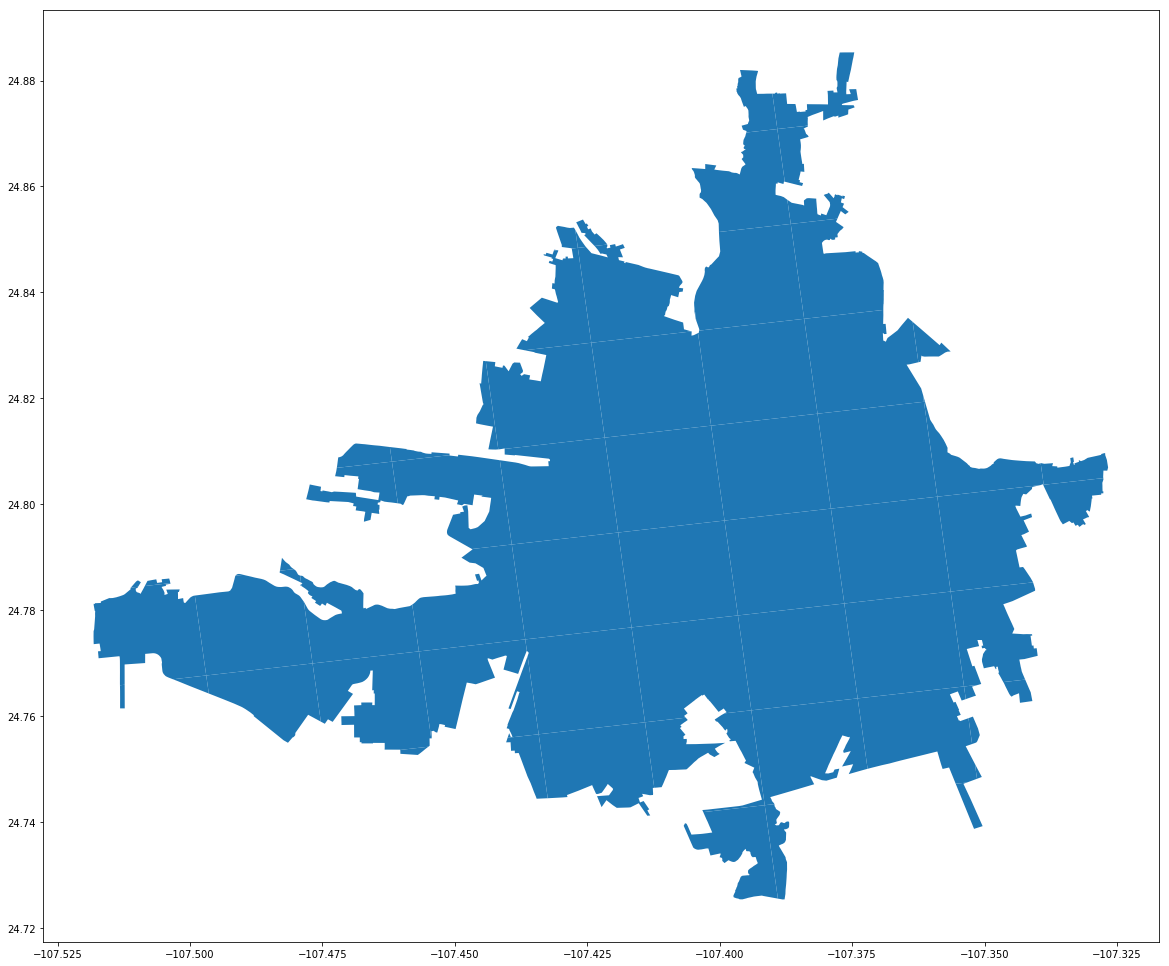

In [36]:
grids[grids.poly==30].plot(figsize=(20,20))

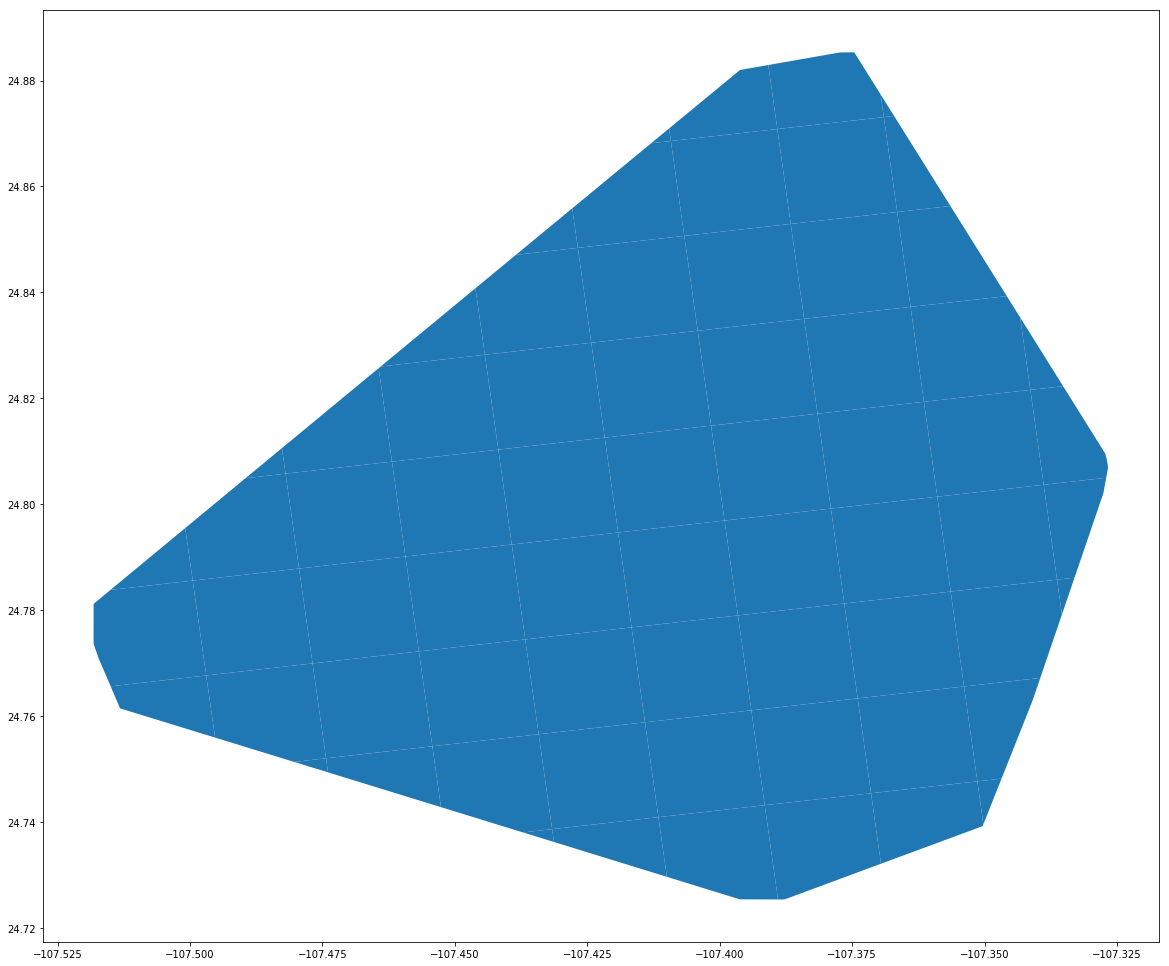

In [60]:
grids_ch[grids_ch.poly==30].plot(figsize=(20,20))

In [ ]:
%lprun -f poly2grids poly2grids(poly, 0.001, False)

In [9]:
gp_poly = gp.GeoDataFrame([poly], columns=['geometry'])

In [10]:
gp_poly.crs = {'init': 'epsg:4326'}